In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from torch import nn
import torch

import sys
sys.path.append('..')
from src.code_help import plot_predictions
from src.code_help import plot_train_test_curves

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0
True


In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

# Data prep

In [4]:
wgt, bias = 0.3, 0.9

X = torch.arange(start=0, end=1, step=0.01).unsqueeze(dim=1)
y = wgt * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120],
         [0.9150],
         [0.9180],
         [0.9210],
         [0.9240],
         [0.9270]]))

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

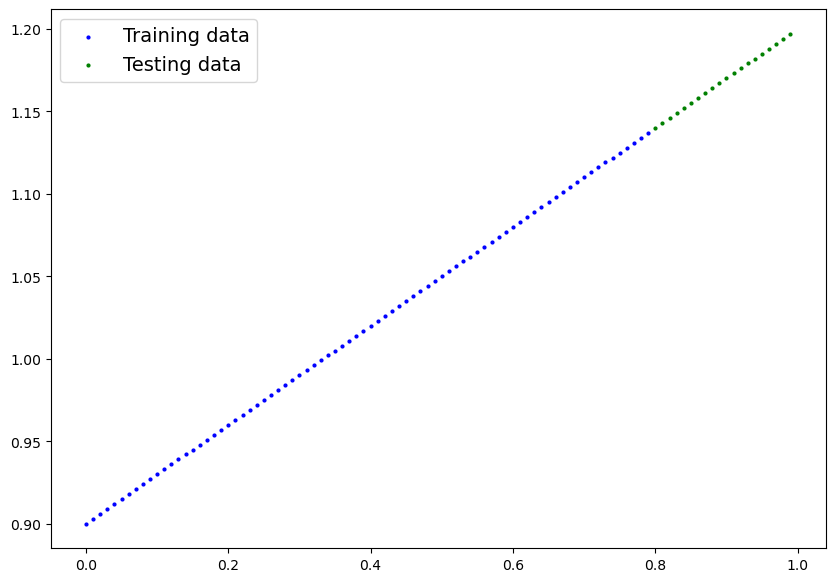

In [6]:
plot_predictions(X_train, y_train, X_test, y_test)

In [7]:
class firstModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [8]:
torch.manual_seed(42)
model_1 = firstModel().to(device)
print(next(model_1.parameters()).device)
params = model_1.parameters()
model_1, model_1.parameters(), model_1.state_dict()

cuda:0


(firstModel(),
 <generator object Module.parameters at 0x7f11fc5312a0>,
 OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
              ('bias', tensor([0.1288], device='cuda:0'))]))

In [9]:
loss_fn = nn.L1Loss()
opt = torch.optim.SGD(params, lr=0.01)

In [10]:
torch.manual_seed(42)
epochs = 300
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch%10 == 0:
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
        epoch_count.append(epoch)

    if epoch%20==0:
        print(f"Epoch :{epoch} | train_loss: {loss:.2f} | test_loss: {test_loss:.2f}")

Epoch :0 | train_loss: 0.76 | test_loss: 0.72
Epoch :20 | train_loss: 0.53 | test_loss: 0.45
Epoch :40 | train_loss: 0.29 | test_loss: 0.18
Epoch :60 | train_loss: 0.08 | test_loss: 0.07
Epoch :80 | train_loss: 0.05 | test_loss: 0.12
Epoch :100 | train_loss: 0.05 | test_loss: 0.10
Epoch :120 | train_loss: 0.04 | test_loss: 0.09
Epoch :140 | train_loss: 0.03 | test_loss: 0.07
Epoch :160 | train_loss: 0.02 | test_loss: 0.06
Epoch :180 | train_loss: 0.02 | test_loss: 0.04
Epoch :200 | train_loss: 0.01 | test_loss: 0.03
Epoch :220 | train_loss: 0.00 | test_loss: 0.01
Epoch :240 | train_loss: 0.00 | test_loss: 0.01
Epoch :260 | train_loss: 0.00 | test_loss: 0.01
Epoch :280 | train_loss: 0.00 | test_loss: 0.01


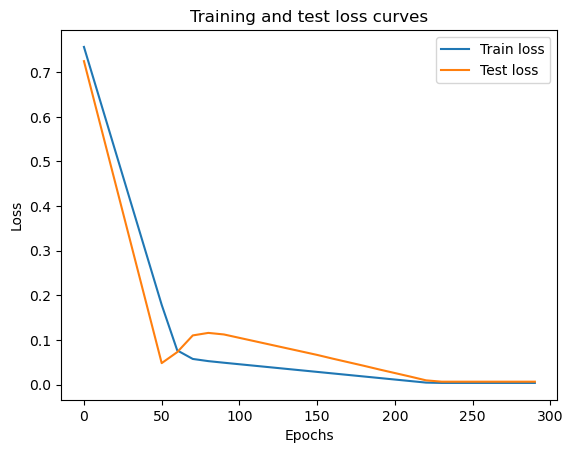

In [11]:
plot_train_test_curves(epoch_count,train_loss_values,test_loss_values)

In [12]:
model_1.state_dict()

OrderedDict([('weights', tensor([0.3067], device='cuda:0')),
             ('bias', tensor([0.9011], device='cuda:0'))])

In [13]:
model_1.eval()
with torch.inference_mode():
    y_preds=model_1(X_test)
y_preds[:10]

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740]], device='cuda:0')

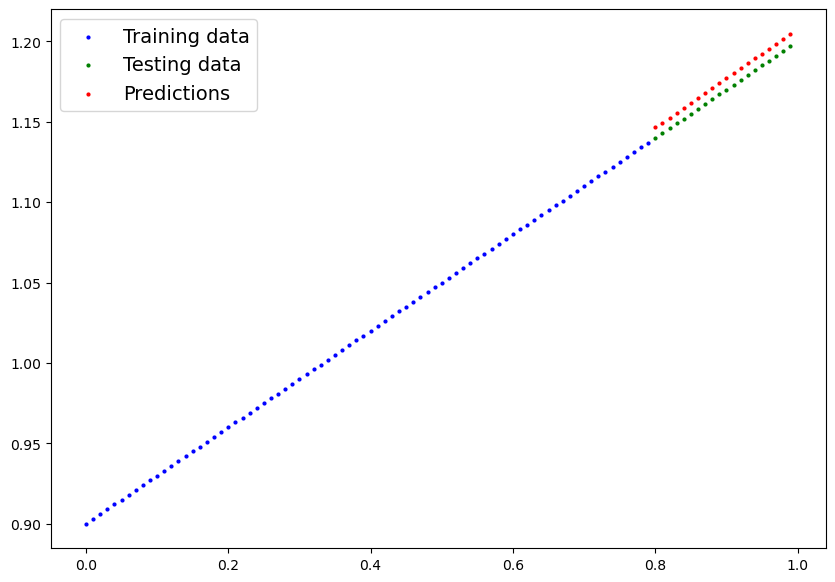

In [14]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

In [20]:
MODEL_PATH = Path("../models")
MODEL_NAME = "01_pytorch_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model to :{MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to :../models/01_pytorch_model_1.pth


In [23]:
load_model_1 = firstModel()
load_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
load_model_1.to(device)

load_model_1,next(load_model_1.parameters()),load_model_1.state_dict()

(firstModel(),
 Parameter containing:
 tensor([0.3067], device='cuda:0', requires_grad=True),
 OrderedDict([('weights', tensor([0.3067], device='cuda:0')),
              ('bias', tensor([0.9011], device='cuda:0'))]))

In [25]:
load_model_1.eval()
with torch.inference_mode():
    load_preds = load_model_1(X_test)
y_preds == load_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')